# Specialized Neural Networks

This notebook shows how to use a pipeline of distinct neural networks to predict
secondary structures.

Specialized models are used to:

- Determine the general aspect of the secondary structure
- Determine the precise pairings of the secondary structure
- Estimate the quality of the structure.

In [1]:
import json
from random import sample

import numpy as np
from torch import optim, nn

from diurnal import database, structure, train, transform, visualize, evaluate, segment
from diurnal.models import deep
from diurnal.models.deep import cnn

## Data Preparation

In [2]:
database.download("./data/", "archiveII")
SRC = "./data/archiveII/"  # Input directory containing the CT files.
SIZE = 128  # RNA molecule maximum length (longer ones are filtered out).
DST = f"./data/archiveII_processed_{SIZE}/"  # Output directory of the formatted files.
names = database.format_filenames(SRC, DST + "names.txt", SIZE)
train_names, validation_names, test_names = train.split(
    names, (0.8, 0.1, 0.1)
)

2024-06-08T21:37:15.520460 > INFO Download and install an RNA database.
2024-06-08T21:37:15.549227 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.
2024-06-08T21:37:15.552443 > INFO Extract the filenames from the directory `./data/archiveII/`.


100%|██████████| 3975/3975 [00:21<00:00, 183.88it/s]


2024-06-08T21:37:37.200242 >     Detected 3975 files. Kept 2326 files.
2024-06-08T21:37:37.209011 >     The file `./data/archiveII_processed_128/names.txt` already contains the names.


In [25]:
def format(dst: str, names: list[str]):
    # Primary structures
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_onehot.npy",
        SIZE, structure.Primary.to_matrix
    )
    pp_scalar = lambda x, y: structure.Primary.to_matrix(
        x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_scalar.npy", SIZE, pp_scalar
    )
    pp_half_scalar = lambda x, y: transform.halve_matrix(
        structure.Primary.to_matrix(
            x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
        )
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_half_scalar.npy",
        SIZE, pp_half_scalar
    )
    database.format_primary_structure(
        names, f"{dst}primary_masks.npy", SIZE, structure.Primary.to_mask
    )
    database.format_primary_structure(
        names, f"{dst}primary_onehot.npy",
        SIZE, structure.Primary.to_onehot
    )
    # Secondary structures.
    database.format_secondary_structure(
        names, f"{dst}secondary_bracket.npy", SIZE,
        structure.Secondary.to_onehot
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_contact.npy", SIZE,
        structure.Secondary.to_matrix
    )
    distance_formatter = lambda x, y: structure.Secondary.to_distance_matrix(
        x, y, power=5
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_distance.npy", SIZE, distance_formatter
    )
    half_distance_formatter = lambda x, y: transform.halve_matrix(
        structure.Secondary.to_distance_matrix(x, y, power=5)
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_distance_half.npy",
        SIZE, half_distance_formatter
    )
    half_contact = lambda x, y: transform.halve_matrix(
        structure.Secondary.to_matrix(x, y)
    )
    database.format_secondary_structure(
        names, f"{dst}contact_half.npy", SIZE, half_contact
    )

In [26]:
format(f"{DST}validation/", validation_names)
format(f"{DST}test/", test_names)
format(f"{DST}train/", train_names)

2024-06-08T20:06:29.423289 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_onehot.npy`.
2024-06-08T20:06:30.336698 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_onehot.npy` already contains the formatted data.
2024-06-08T20:06:30.338702 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy`.
2024-06-08T20:06:30.381771 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy` already contains the formatted data.
2024-06-08T20:06:30.383398 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_half_scalar.npy`.
2024-06-08T20:06:30.422733 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_half_scalar.npy` already contains the formatted data.
2024-06-08T20:06:30.424737 > INFO Formatting primar

In [3]:
def evaluate_model(model, data, is_half: bool = True) -> list[float]:
    f1 = []
    for i in range(len(data["output"])):
        p = model.predict([data["input"][0][i]])
        p *= data["mask"][i]
        p = transform.quantize(p, is_half)
        t = data["target"][i]
        f1.append(evaluate.ContactMatrix.f1(t, p))
    return f1


def check(model, data, index, is_half: bool = True):
    p = model.predict([data["input"][0][index]])
    visualize.heatmap(p)
    p = transform.quantize(p * data["mask"][index], is_half)
    t = data["target"][index]
    visualize.compare_pairings(t, p)
    print(f"F1 score: {evaluate.ContactMatrix.f1(t, p)}")

## Secondary Structure Approximator

In [4]:
def format_data(input, output) -> tuple:
    train_set = {
        "input": (np.load(f"{DST}train/{input}.npy"), ),
        "output": np.load(f"{DST}train/{output}.npy"),
        "mask": np.load(f"{DST}train/primary_masks.npy"),
        "names": []
    }
    validation_set = {
        "input": (np.load(f"{DST}validation/{input}.npy"), ),
        "output": np.load(f"{DST}validation/{output}.npy"),
        "mask": np.load(f"{DST}validation/primary_masks.npy"),
        "names": []
    }
    test_set = {
        "input": (np.load(f"{DST}test/{input}.npy"), ),
        "output": np.load(f"{DST}test/{output}.npy"),
        "target": np.load(f"{DST}test/secondary_contact.npy"),
        "mask": np.load(f"{DST}test/primary_masks.npy"),
        "names": []
    }
    return train_set, validation_set, test_set

In [30]:
def benchmark(input: str, output: str, model: any, is_half: bool):
    t, v, tt = format_data(input, output)
    N_MAX_EPOCHS = 500
    model = deep.NN(
        model=model,
        n_epochs=N_MAX_EPOCHS,
        optimizer=optim.Adam,
        loss_fn=nn.CrossEntropyLoss,
        optimizer_args={"eps": 1e-4},
        loss_fn_args=None,
        use_half=False,
        patience=5,
        verbosity=2,
    )
    model.train(t, v)
    perf = evaluate_model(model, tt, is_half)
    print(np.mean(perf))
    return np.mean(perf)

In [9]:
results = {"half": {}, "full": {}}
for i in range(2, 6):
    #h = benchmark(
    #    "primary_potential_pairings_half_scalar",
    #    "secondary_distance_half",
    #    cnn.UNet2D(SIZE, i),
    #    True
    #)
    f = benchmark(
        "primary_potential_pairings_scalar",
        "secondary_contact",
        cnn.UNet2D(SIZE, i),
        False
    )
    #results["half"][i] = h
    results["full"][i] = f

print(json.dumps(results, indent=4))

2024-06-06T22:09:29.740891 > INFO Training the model with 1860 data points.
2024-06-06T22:09:29.742900 >     Using 232 data points for validation.
2024-06-06T22:09:29.743900 >     Beginning the training.
2024-06-06T22:09:34.006388 >   0 / 500 [                                                  ] Loss: 2.13935  Patience: 5
2024-06-06T22:09:34.627158 >   1 / 500 [                                                  ] Loss: 2.08764  Patience: 5
2024-06-06T22:09:35.251835 >   2 / 500 [                                                  ] Loss: 2.07128  Patience: 5
2024-06-06T22:09:35.916353 >   3 / 500 [                                                  ] Loss: 2.06324  Patience: 5
2024-06-06T22:09:36.568784 >   4 / 500 [                                                  ] Loss: 2.05687  Patience: 5
2024-06-06T22:09:37.211278 >   5 / 500 [                                                  ] Loss: 2.05260  Patience: 5
2024-06-06T22:09:37.851168 >   6 / 500 [                                          

Bilinear, MSELoss:

```
{
    "half": {
        "2": 0.14002722428694112,
        "3": 0.22412354973594434,
        "4": 0.24184887997549157,
        "5": 0.17150800106725816
    },
    "full": {
        "2": 0.25750374166166473,
        "3": 0.19914820824813997,
        "4": 0.15881814373303846,
        "5": 0.2086799383275853
    }
}
```

Nearest, MSELoss:

```
{
    "half": {
        "2": 0.14497220223962232,
        "3": 0.13312604660489435,
        "4": 0.13099839857875786,
        "5": 0.14005017982282
    },
    "full": {
        "2": 0.20398047561596694,
        "3": 0.14966895208886727,
        "4": 0.19901330726510236,
        "5": 0.1312544694459387
    }
}
```

Nearest, CrossEntropy:

```
"full": {
    "2": 0.5233073420260616,
    "3": 0.5351836436974078,
    "4": 0.45687957692505987,
    "5": 0.3744085404443844
}
```

Bilinear, CrossEntropy:

```
"full": {
    "2": 0.5260070533218697,
    "3": 0.5066470320593437,
    "4": 0.4874086688545629,
    "5": 0.5115815666745064
}
```

In [37]:
t, v, tt = format_data(
    "primary_potential_pairings_scalar",
    "secondary_distance",
)

N_MAX_EPOCHS = 500
model = deep.NN(
    model=cnn.UNet2D(SIZE, 4),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.CrossEntropyLoss,
    loss_fn_args=None,
    use_half=False,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-06-08T20:09:49.003721 > INFO Training the model with 1860 data points.
2024-06-08T20:09:49.006229 >     Using 232 data points for validation.
2024-06-08T20:09:49.006229 >     Beginning the training.
2024-06-08T20:09:50.291553 >   0 / 500 [                                                  ] Loss: 228.50514  Patience: 5
2024-06-08T20:09:51.203063 >   1 / 500 [                                                  ] Loss: 228.18015  Patience: 5
2024-06-08T20:09:52.138969 >   2 / 500 [                                                  ] Loss: 227.93054  Patience: 5
2024-06-08T20:09:53.042815 >   3 / 500 [                                                  ] Loss: 227.74001  Patience: 5
2024-06-08T20:09:53.954119 >   4 / 500 [                                                  ] Loss: 227.59768  Patience: 5
2024-06-08T20:09:54.835929 >   5 / 500 [                                                  ] Loss: 227.50844  Patience: 5
2024-06-08T20:09:55.718086 >   6 / 500 [                              

[0.032786883413791656, 0.15555554628372192, 0.06976743787527084, 0.13636364042758942, 0.0, 0.033898308873176575, 0.07547170668840408, 0.0, 0.04878048971295357, 0.1149425283074379, 0.10526316612958908, 0.07017544656991959, 0.1071428582072258, 0.10989011079072952, 0.0731707364320755, 0.10810811072587967, 0.21176470816135406, 0.09195402264595032, 0.0, 0.0238095261156559, 0.10869564861059189, 0.03389830142259598, 0.11764705926179886, 0.0476190522313118, 0.09090909361839294, 0.17204301059246063, 0.09090909361839294, 0.11627907305955887, 0.07407407462596893, 0.06896551698446274, 0.04878048971295357, 0.1149425283074379, 0.037037041038274765, 0.1149425283074379, 0.10752688348293304, 0.0, 0.03703703731298447, 0.04878048971295357, 0.14457832276821136, 0.0, 0.1111111119389534, 0.025316458195447922, 0.1318681389093399, 0.06976743787527084, 0.0784313753247261, 0.1411764770746231, 0.022727273404598236, 0.06896550953388214, 0.10958904027938843, 0.27397260069847107, 0.048192769289016724, 0.0, 0.139534

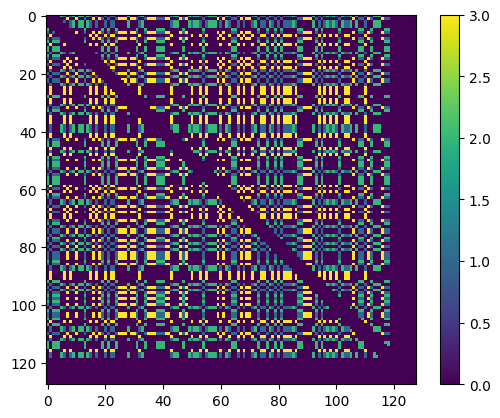

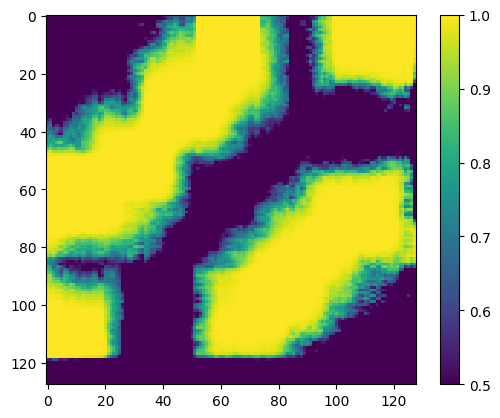

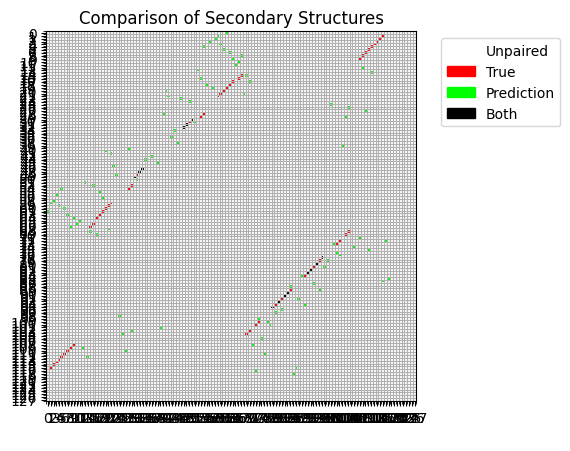

F1 score: 0.15555554628372192


In [38]:
p = evaluate_model(model, tt, False)
print(p)
print(np.mean(p))
visualize.heatmap(tt["input"][0][1])
check(model, tt, 1)

In [5]:
t, v, tt = format_data(
    "primary_potential_pairings_scalar",
    "secondary_contact",
)


N_MAX_EPOCHS = 100
model = deep.NN(
    model=cnn.UNet2D(SIZE, 4),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.CrossEntropyLoss,
    loss_fn_args=None,
    use_half=False,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-06-08T21:37:52.587306 > INFO Training the model with 1860 data points.
2024-06-08T21:37:52.589311 >     Using 232 data points for validation.
2024-06-08T21:37:52.590313 >     Beginning the training.
2024-06-08T21:37:59.045319 >   0 / 100 [                                                  ] Loss: 2.11270  Patience: 5
2024-06-08T21:38:00.004270 >   1 / 100 [                                                  ] Loss: 2.07523  Patience: 5
2024-06-08T21:38:00.922739 >   2 / 100 [=                                                 ] Loss: 2.05915  Patience: 5
2024-06-08T21:38:01.811218 >   3 / 100 [=                                                 ] Loss: 2.04935  Patience: 5
2024-06-08T21:38:02.676270 >   4 / 100 [==                                                ] Loss: 2.04231  Patience: 5
2024-06-08T21:38:03.524878 >   5 / 100 [==                                                ] Loss: 2.03946  Patience: 5
2024-06-08T21:38:04.456372 >   6 / 100 [===                                       

[0.5714285969734192, 0.6373625993728638, 0.7906976938247681, 0.6813187003135681, 0.10256411135196686, 0.46666666865348816, 0.5714285373687744, 0.5862069129943848, 0.6222222447395325, 0.7640449404716492, 0.5862069129943848, 0.5263158082962036, 0.7017543911933899, 0.7173913717269897, 0.7441860437393188, 0.2631579041481018, 0.6813187003135681, 0.6304347515106201, 0.5263158082962036, 0.7380951642990112, 0.6304347515106201, 0.23333334922790527, 0.47887322306632996, 0.5116279125213623, 0.3863636255264282, 0.6304347515106201, 0.6666667461395264, 0.7441861033439636, 0.4814814627170563, 0.6511628031730652, 0.45783132314682007, 0.7954545021057129, 0.37037038803100586, 0.7816091775894165, 0.717391312122345, 0.05405405908823013, 0.6206896901130676, 0.5054944753646851, 0.7111111283302307, 0.44736841320991516, 0.7499999403953552, 0.3499999940395355, 0.695652186870575, 0.65116286277771, 0.7017543911933899, 0.6818181872367859, 0.29885056614875793, 0.517241358757019, 0.44736841320991516, 0.444444447755

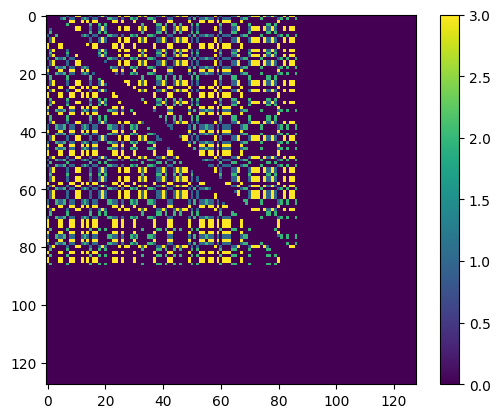

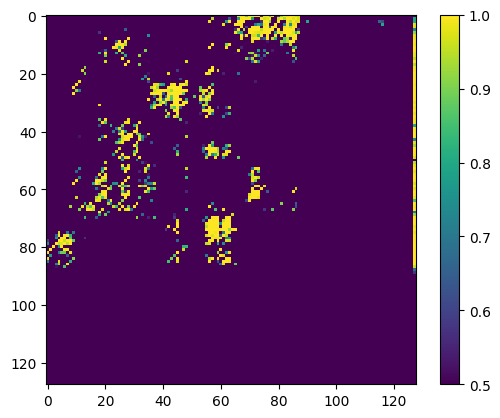

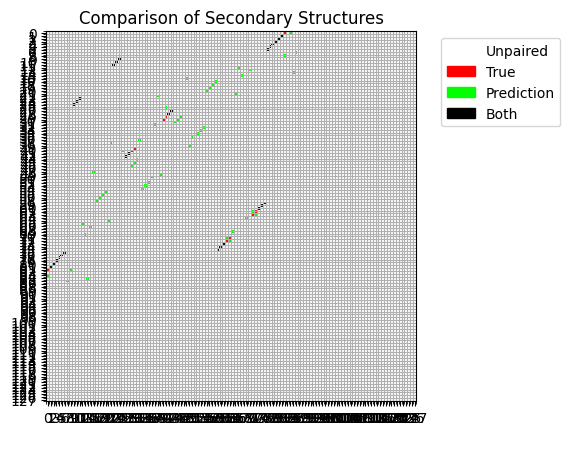

F1 score: 0.46666666865348816


In [10]:
p = evaluate_model(model, tt, False)
print(p)
print(np.mean(p))
index = 5
visualize.heatmap(tt["input"][0][index])
check(model, tt, index)

In [ ]:
from os import mkdir

try:
    mkdir("tmp")
except:
    pass

from tqdm import tqdm

predictions = []
for i in tqdm(range(len(t["input"][0]))):
    p = model.predict([t["input"][0][i]])
    predictions.append(p)
np.save("tmp/train_predictions.npy", np.array(predictions))

predictions = []
for i in tqdm(range(len(v["input"][0]))):
    p = model.predict([v["input"][0][i]])
    predictions.append(p)
np.save("tmp/validation_predictions.npy", np.array(predictions))

predictions = []
for i in tqdm(range(len(tt["input"][0]))):
    p = model.predict([tt["input"][0][i]])
    predictions.append(p)
np.save("tmp/test_predictions.npy", np.array(predictions))

## Low-Pass Filter

In [17]:
import scipy.ndimage


class FilteredModel():
    def __init__(self, model):
        self.model = model

    def predict(self, ppm, mask):
        p = self.model.predict(ppm)
        p *= mask
        p = transform.quantize(p, False)
        tmp = scipy.ndimage.convolve(p, np.ones((3,3)), mode='constant')
        out = np.logical_and(tmp >= 2, p).astype(np.float32)
        return out

low_pass = FilteredModel(model)


def evaluate_filtered_model(model, data, is_half: bool = True) -> list[float]:
    f1 = []
    for i in range(len(data["output"])):
        p = model.predict([data["input"][0][i]], data["mask"][i])
        t = data["target"][i]
        f1.append(evaluate.ContactMatrix.f1(t, p))
    return f1


def check(model, data, index, is_half: bool = True):
    p = model.predict([data["input"][0][index]], data["mask"][index])
    visualize.heatmap(p)
    t = data["target"][index]
    visualize.compare_pairings(t, p)
    print(f"F1 score: {evaluate.ContactMatrix.f1(t, p)}")

[0.6829268336296082, 0.7384615540504456, 0.8358209133148193, 0.5161290168762207, 0.0, 0.34285712242126465, 0.6666666865348816, 0.6976744532585144, 0.4444444179534912, 0.746268630027771, 0.6341463327407837, 0.06060606241226196, 0.555555522441864, 0.7887324094772339, 0.9275362491607666, 0.10256410390138626, 0.8235294222831726, 0.6153846383094788, 0.8095238208770752, 0.7352941036224365, 0.7384615540504456, 0.2666666507720947, 0.4000000059604645, 0.7272728085517883, 0.290909081697464, 0.8615384697914124, 0.6301369667053223, 0.9014084935188293, 0.550000011920929, 0.75, 0.2222222089767456, 0.7384616136550903, 0.21739129722118378, 0.688524603843689, 0.8571428656578064, 0.21052633225917816, 0.6666666865348816, 0.5333333015441895, 0.8695652484893799, 0.5333333611488342, 0.6764705777168274, 0.41860464215278625, 0.7076922655105591, 0.8923077583312988, 0.7272727489471436, 0.8358209133148193, 0.1818181872367859, 0.05882352963089943, 0.3913043737411499, 0.30434781312942505, 0.3396226763725281, 0.0, 

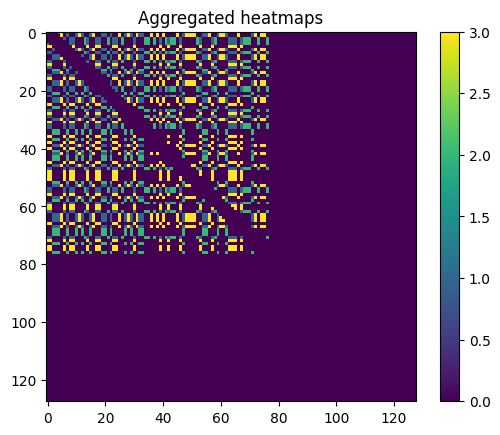

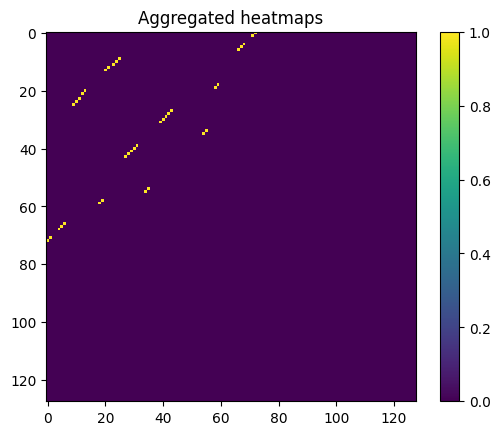

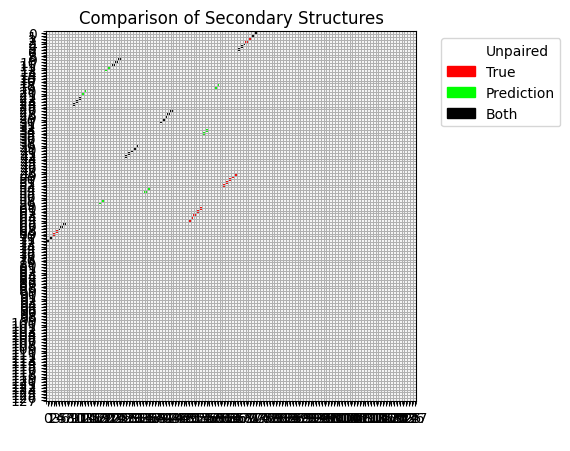

F1 score: 0.6666666865348816


In [23]:
p = evaluate_filtered_model(low_pass, tt, False)
print(p)
print(np.mean(p))
visualize.heatmap(tt["input"][0][6])
check(low_pass, tt, 6)

## Secondary Structure Refiner

Blocks:

1. Global structure estimator - GSE (Autoencoder, UNet)
2. Contraint unit - CU (mask multiplication)
3. Monomialization unit - MU (function)
4. Low-pass filter - LPF (threshold on convoluted sum, NN) / Denoiser / Clusterer / Thresholder
5. Local structure refiner - LSR (NN)
6. Symmetrization unit

Acyclic Graphs:

* GSE -> CU -> MU -> LPF -> LSR
* GSE -> CU -> LPF -> LSR -> MU
* GSE -> CU -> LPF -> MU -> LSR -> MU

In [85]:
t, v, tt = format_data(
    "primary_potential_pairings_scalar",
    "secondary_contact",
)
contact_t = np.load("tmp/train_predictions.npy")
contact_v = np.load("tmp/validation_predictions.npy")
contact_tt = np.load("tmp/test_predictions.npy")

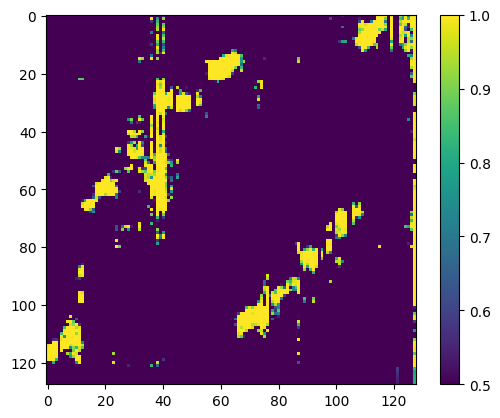

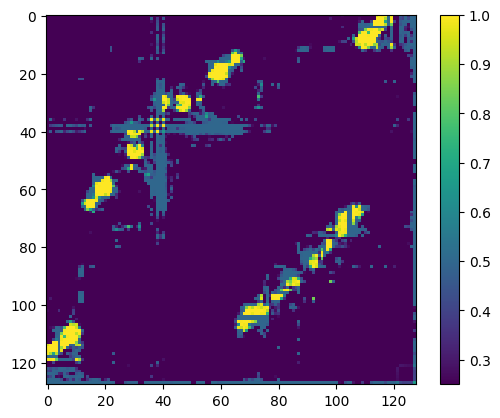

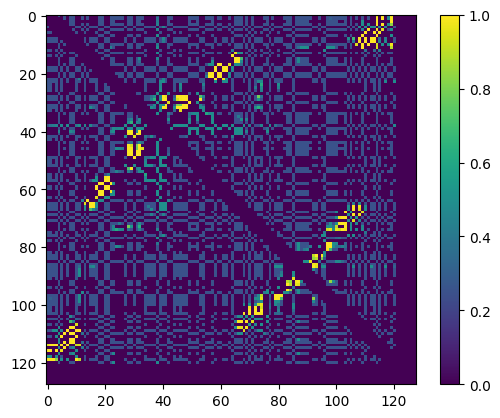

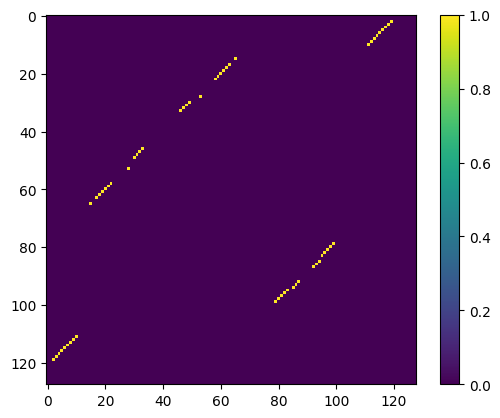

In [86]:
index = 1
visualize.heatmap(contact_t[index])
visualize.heatmap(contact_t[index] * contact_t[index].T)
visualize.heatmap(contact_t[index] * contact_t[index].T * t["mask"][index])
visualize.heatmap(t["output"][index])

[((64, 80), 147.70459), ((80, 64), 147.70459), ((16, 32), 144.57675), ((32, 16), 144.57675), ((16, 48), 139.51842), ((48, 16), 139.51842), ((0, 32), 134.20953), ((32, 0), 134.20953), ((48, 0), 131.58261), ((0, 48), 131.5826), ((16, 16), 131.39001), ((48, 80), 120.178345), ((80, 48), 120.178345), ((0, 64), 119.81676), ((64, 0), 119.81676), ((16, 64), 119.42905), ((64, 16), 119.42903), ((0, 80), 118.707306), ((80, 0), 118.70729), ((0, 96), 113.91228), ((96, 0), 113.91228), ((0, 16), 112.91343), ((16, 0), 112.91343), ((64, 96), 111.80844), ((96, 64), 111.80844), ((64, 64), 111.25064), ((80, 80), 108.40566), ((16, 80), 104.923416), ((80, 16), 104.92341), ((32, 64), 103.482605), ((64, 32), 103.482605), ((48, 96), 98.626434), ((96, 48), 98.626434), ((32, 32), 96.79117), ((32, 48), 95.25879), ((48, 32), 95.25879), ((32, 80), 93.75046), ((80, 32), 93.75046), ((0, 0), 88.88011), ((48, 64), 88.55191), ((64, 48), 88.55191), ((16, 96), 79.4723), ((96, 16), 79.4723), ((48, 48), 73.5), ((80, 96), 71

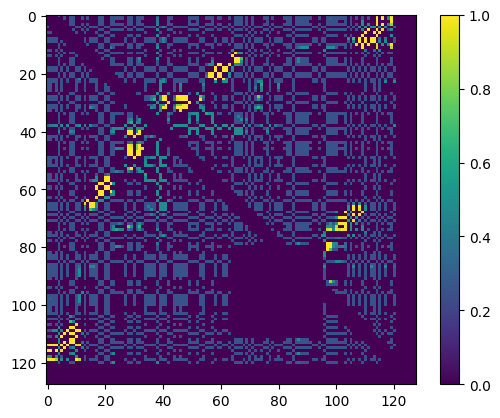

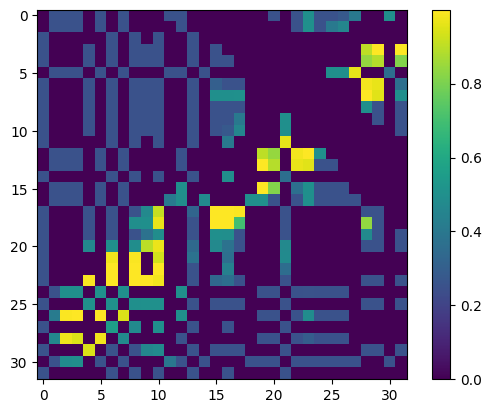

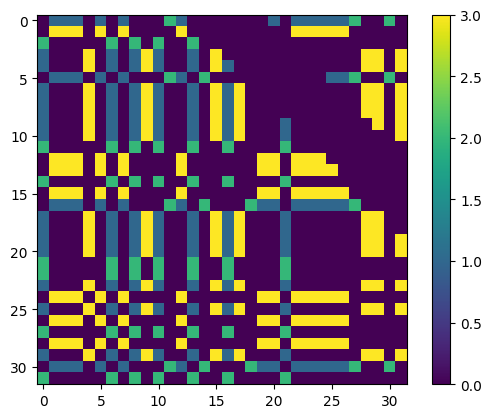

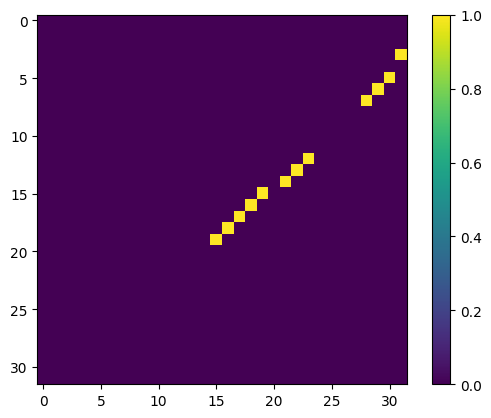

In [87]:
areas = []
a = contact_t[index] * contact_t[index].T * t["mask"][index]
#visualize.heatmap(a)
b = segment.sample_areas(a, 32, 8, stride=16)
print(b)
print(len(b))
c = a.copy()
indices = b[index][0]
c[indices[0]: indices[0] + 32, indices[1]: indices[1] + 32] = 0
visualize.heatmap(c)
# np.save("tmp/train_samples_32.npy", np.array(predictions))

predict_crop = a[indices[0]: indices[0] + 32, indices[1]: indices[1] + 32]
pp_crop = t["input"][0][index][indices[0]: indices[0] + 32, indices[1]: indices[1] + 32]
contact_crop = t["output"][index][indices[0]: indices[0] + 32, indices[1]: indices[1] + 32]
visualize.heatmap(predict_crop)
visualize.heatmap(pp_crop)
visualize.heatmap(contact_crop)

In [88]:
FIRST = 16  # Select the most important areas.
RANDOM = 8  # Select random areas after the FIRST ones.
STRIDE = 16
N = 32

from tqdm import tqdm


def sample_crops(predictions, data, name, maximum) -> list:
    predict_crops = []
    pp_crops = []  # Potential pairings
    contact_crops = []
    for index in tqdm(range(len(predictions))):
        prediction = predictions[index] * predictions[index].T * data["mask"][index]
        all_crops = segment.sample_areas(prediction, N, N, stride=STRIDE)
        if len(all_crops) > FIRST:
            difference = len(all_crops) - FIRST
            sampling = min(difference, RANDOM)
            if sampling:
                crops = all_crops[:FIRST] + sample(all_crops[FIRST:], sampling)
            else:
                crops = all_crops[:FIRST]
        else:
            crops = all_crops

        for crop, _ in crops:
            predict_crops.append(
                predictions[index][crop[0]: crop[0] + 32, crop[1]: crop[1] + 32]
            )
            pp_crops.append(
                data["input"][0][index][crop[0]: crop[0] + 32, crop[1]: crop[1] + 32]
            )
            contact_crops.append(
                data["output"][index][crop[0]: crop[0] + 32, crop[1]: crop[1] + 32]
            )

        if len(predict_crops) >= maximum:
            break

    np.save(f"tmp/{name}_areas_prediction_32.npy", np.array(predict_crops))
    np.save(f"tmp/{name}_areas_pp_32.npy", np.array(pp_crops))
    np.save(f"tmp/{name}_areas_contact_32.npy", np.array(contact_crops))


sample_crops(contact_t, t, "train", 30_000)
sample_crops(contact_v, v, "validation", 5_000)
sample_crops(contact_tt, tt, "test", 5_000)

 93%|█████████▎| 216/232 [00:00<00:00, 3585.87it/s]


In [89]:
a = np.load("tmp/validation_areas_prediction_32.npy")
print(len(a))
a = np.load("tmp/test_areas_prediction_32.npy")
print(len(a))
a = np.load("tmp/train_areas_prediction_32.npy")
print(len(a))

5012
5017
30002


In [90]:
a = np.load("tmp/train_areas_prediction_32.npy")
b = np.load("tmp/train_areas_pp_32.npy")
c = np.load("tmp/train_areas_contact_32.npy")

In [91]:
diff = []
for i in range(len(a)):
    a1 = sum(a[i])
    a2 = sum(c[i])
    if a2.sum() < 1 and a1.sum() > 8:
        diff.append(i)

print(len(diff))
print(len(a))

7245
30002


[10, 11, 16, 19, 20, 21, 22, 39, 40, 42, 43, 45, 47, 59, 60, 65, 69, 86, 88, 90]


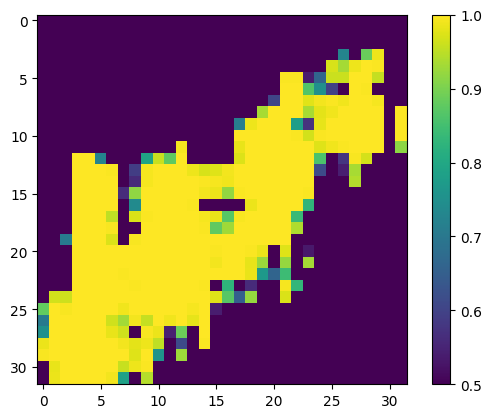

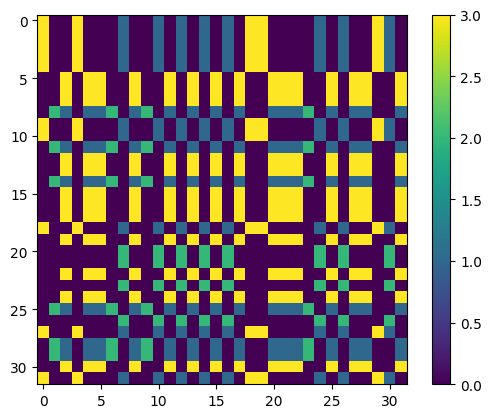

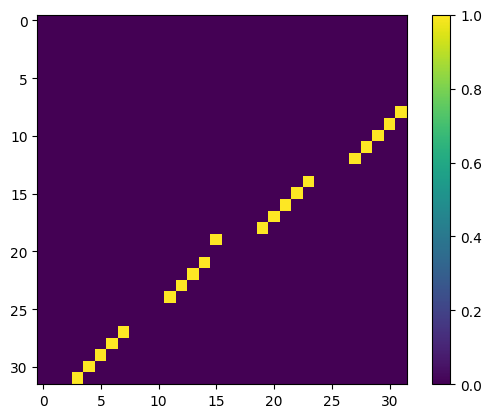

In [92]:
print(diff[:20])
index = 0
visualize.heatmap(a[index])
visualize.heatmap(b[index])
visualize.heatmap(c[index])

In [45]:
dirname = "tmp"

def format_data() -> tuple:
    train_set = {
        "input": (
            np.load(f"{dirname}/train_areas_prediction_32.npy"),
            np.load(f"{dirname}/train_areas_pp_32.npy")
        ),
        "output": np.load(f"{dirname}/train_areas_contact_32.npy"),
        "names": []
    }
    validation_set = {
        "input": (
            np.load(f"{dirname}/validation_areas_prediction_32.npy"),
            np.load(f"{dirname}/validation_areas_pp_32.npy")
        ),
        "output": np.load(f"{dirname}/validation_areas_contact_32.npy"),
        "names": []
    }
    test_set = {
        "input": (
            np.load(f"{dirname}/test_areas_prediction_32.npy"),
            np.load(f"{dirname}/test_areas_pp_32.npy")
        ),
        "output": np.load(f"{dirname}/test_areas_contact_32.npy"),
        "names": []
    }
    return train_set, validation_set, test_set

### Attempt 1

In [55]:
t, v, tt = format_data()

In [60]:
from torch.functional import F
from torch import stack, squeeze, cat

class EX(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding="same")
        self.conv2 = nn.Conv2d(2, 1, 3, padding="same")
        self.linear = nn.Linear(n, n)
        self.activation = F.relu
        self.output = nn.Sigmoid()

    def forward(self, x, y):
        x = stack((x, ), dim=1)
        y = stack((y, ), dim=1)
        x = self.conv1(x)
        x = self.activation(x)
        y = self.conv1(y)
        y = self.activation(y)
        z = cat((x, y), 1)
        z = self.conv2(z)
        z = self.activation(z)
        z = self.linear(z)
        z = self.output(z)
        z = squeeze(z)
        return z


class EX2(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding="same")
        self.conv2 = nn.Conv2d(2, 1, 3, padding="same")
        self.linear1 = nn.Linear(n, n)
        self.down = nn.AdaptiveAvgPool2d(int(n / 2))
        self.linear2 = nn.Linear(int(n / 2), int(n / 2))
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        self.linear3 = nn.Linear(n, n)
        self.activation = F.relu
        self.output = nn.Sigmoid()

    def forward(self, x, y):
        x = stack((x, ), dim=1)
        y = stack((y, ), dim=1)
        x = self.conv1(x)
        x = self.activation(x)
        y = self.conv1(y)
        y = self.activation(y)
        z = cat((x, y), 1)

        z = self.conv2(z)
        z = self.activation(z)
        z = self.linear1(z)
        z = self.down(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.conv1(z)
        z = self.activation(z)
        z = self.up(z)
        z = self.linear3(z)
        z = self.activation(z)
        z = self.conv1(z)

        z = self.output(z)
        z = squeeze(z)
        return z

In [65]:
from torch import mean

class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, pred, y):
        loss = mean((pred - y * 2)**2)
        return loss


N_MAX_EPOCHS =500
model = deep.NN(
    model=EX2(32),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.CrossEntropyLoss,
    # loss_fn=CustomLoss,
    loss_fn_args=None,
    use_half=False,
    patience=10,
    verbosity=2,
    batch=256
)
model.train(t, v)

2024-06-08T20:36:29.389352 > INFO Training the model with 30002 data points.
2024-06-08T20:36:29.390863 >     Using 5012 data points for validation.
2024-06-08T20:36:29.392383 >     Beginning the training.
2024-06-08T20:36:30.878439 >   0 / 500 [                                                  ] Loss: 0.70653  Patience: 10
2024-06-08T20:36:31.926323 >   1 / 500 [                                                  ] Loss: 0.70470  Patience: 10
2024-06-08T20:36:33.039041 >   2 / 500 [                                                  ] Loss: 0.70076  Patience: 10
2024-06-08T20:36:34.223935 >   3 / 500 [                                                  ] Loss: 0.69266  Patience: 10
2024-06-08T20:36:35.224085 >   4 / 500 [                                                  ] Loss: 0.67408  Patience: 10
2024-06-08T20:36:36.231964 >   5 / 500 [                                                  ] Loss: 0.65466  Patience: 10
2024-06-08T20:36:37.326895 >   6 / 500 [                                  

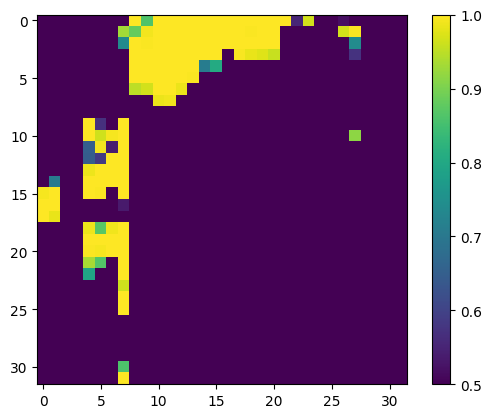

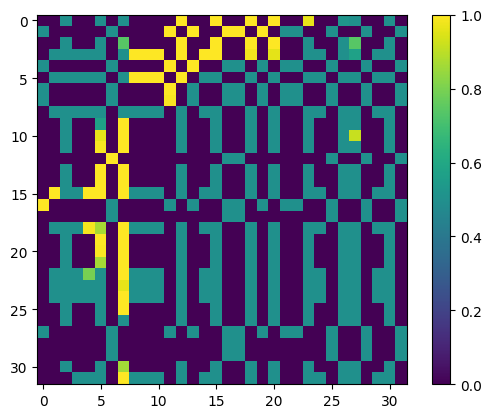

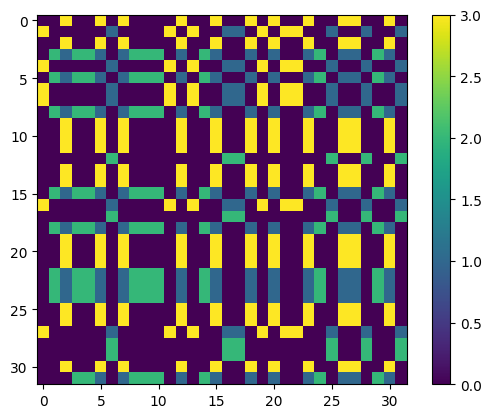

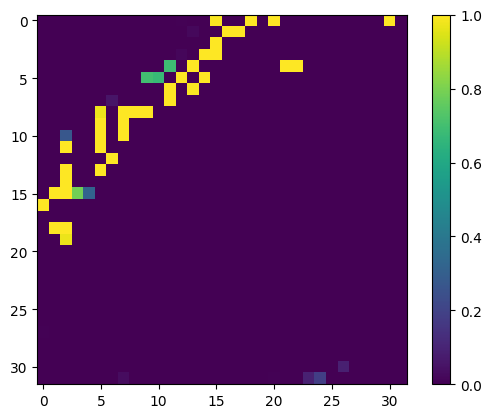

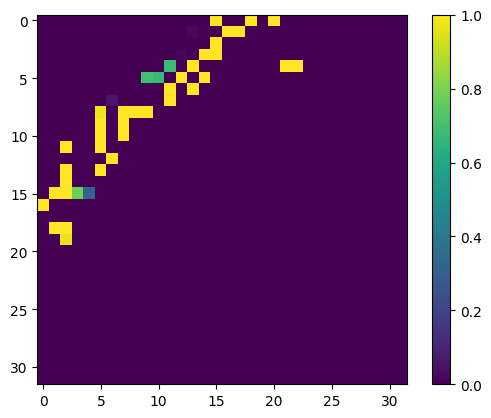

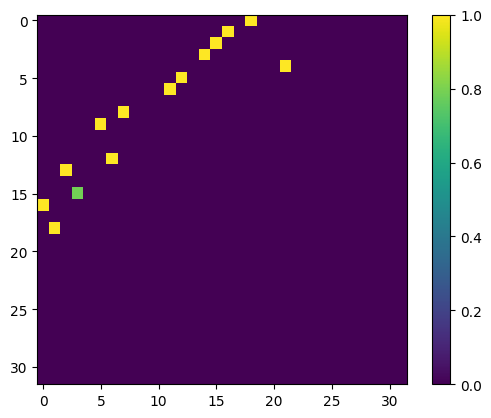

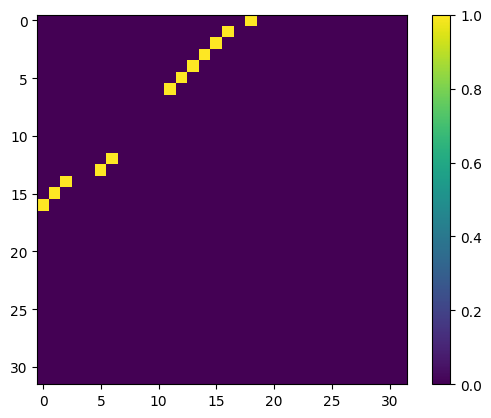

In [147]:
index = 24
m = tt["input"][1][index].copy()
m[m > 0] = 1
visualize.heatmap(tt["input"][0][index])
visualize.heatmap(tt["input"][0][index] * m)
visualize.heatmap(tt["input"][1][index])

from torch import from_numpy

def predict(input: any) -> np.ndarray:
    model.nn.eval()
    a = from_numpy(np.array([input[0].T])).to("cuda")
    b = from_numpy(np.array([input[1].T])).to("cuda")
    pred = model.nn(a, b)
    if model.device == "cuda":
        return pred.detach().cpu().numpy()
    return pred

p = predict([tt["input"][0][index], tt["input"][1][index]])
visualize.heatmap(p * m)
visualize.heatmap(segment.convolutional_denoise(p * m, 5) * p * m)
visualize.heatmap(transform.to_monomial_matrix(segment.convolutional_denoise(p * m, 5) * p * m))
visualize.heatmap(tt["output"][index])
r = p * m

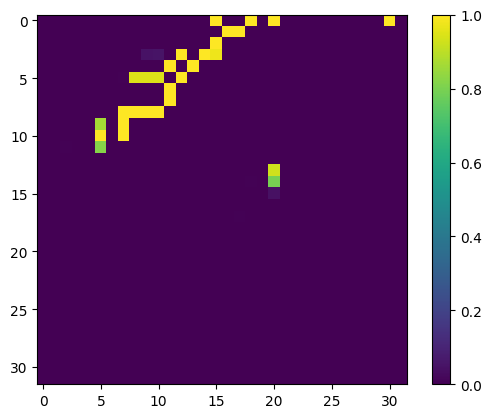

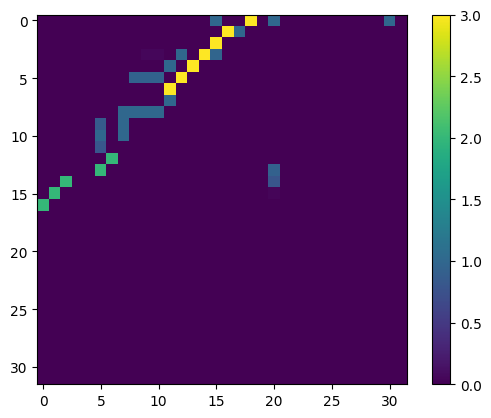

In [142]:
p = predict([r, tt["input"][1][index]])
visualize.heatmap(p * m)
r = p * m
visualize.heatmap(r + tt["output"][index] * 2)